In [1]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from scipy.linalg import orthogonal_procrustes

import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed

from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed
from scipy.linalg import orthogonal_procrustes
from graspologic.plot import heatmap
from sklearn.manifold import Isomap
import piecewise_regression
from sklearn.linear_model import LinearRegression


from kneed import DataGenerator, KneeLocator


plt.ion()


import warnings

def find_optimal_neighbors(X):
    n_neighbors = 2
    while True:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                isomap = Isomap(n_neighbors=n_neighbors)
                isomap.fit(X)
                print(f"Successful with n_neighbors={n_neighbors}")
                return n_neighbors
        except Warning as w:
            print(f"Warning encountered with n_neighbors={n_neighbors}: {w}")
            n_neighbors += 1




from scipy.stats import norm

def get_elbows(dat, n=3, threshold=False, plot=True, main=""):
    """
    Given a decreasingly sorted vector, return the given number of elbows.

    Args:
        dat: an input vector (e.g. a vector of standard deviations) or an input feature matrix.
        n: the number of returned elbows.
        threshold: either False or a number. If threshold is a number, then all
                   the elements in dat that are not larger than the threshold will be ignored.
        plot: logical. When True, it depicts a scree plot with highlighted elbows.
        main: title for the plot.

    Returns:
        q: a list of length n containing the positions of the elbows.
    """
    
    if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
        d = np.sort(np.std(dat, axis=0))[::-1]
    else:
        d = np.sort(dat)[::-1]

    if threshold is not False:
        d = d[d > threshold]

    p = len(d)
    if p == 0:
        raise ValueError(f"d must have elements that are larger than the threshold {threshold}!")

    lq = np.zeros(p)  # log likelihood, function of q
    for q in range(p):
        mu1 = np.mean(d[:q+1])
        mu2 = np.mean(d[q+1:]) if q < p-1 else np.nan
        sigma2 = (np.sum((d[:q+1] - mu1)**2) + np.sum((d[q+1:] - mu2)**2)) / (p - 1 - (q < p-1))
        lq[q] = (np.sum(norm.logpdf(d[:q+1], mu1, np.sqrt(sigma2))) + 
                 np.sum(norm.logpdf(d[q+1:], mu2, np.sqrt(sigma2))))

    q = [np.argmax(lq)]
    if n > 1 and q[0] < (p - 1):
        q.extend([q[0] + 1 + el for el in get_elbows(d[q[0]+1:], n-1, plot=False)])

    if plot:
        if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
            sdv = d
            plt.plot(sdv, marker='o')
            plt.xlabel("dim")
            plt.ylabel("stdev")
            plt.title(main)
            plt.scatter(q, sdv[q], s=100, color='red')
        else:
            plt.plot(dat, marker='o')
            plt.title(main)
            plt.scatter(q, dat[q], s=100, color='red')
        plt.show()

    return q

def filter_matrix_TC(data, well, win):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well][win]['adj_matrix_predicted']
    votes = data[well][win]['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well][win]['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix


In [2]:
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Run_8_TBS_Experiment_ecr_results_windowed/'
dr1=dr+'230601 RUN 8 Wells 1-3'
dr2=dr+'230602 RUN 8 Wells 4-6'

filenames=os.listdir(dr1)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))
sorted_filenames_updated1=['230601 RUN 8 Wells 1-3/'+filename + '/data.raw_20240415_18h04m.pkl' for filename in sorted_filenames]

filenames=os.listdir(dr2)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))
sorted_filenames_updated2=['230602 RUN 8 Wells 4-6/'+filename + '/data.raw_20240415_18h04m.pkl' for filename in sorted_filenames]

sorted_filenames_updated=sorted_filenames_updated1+sorted_filenames_updated2

In [3]:
well='well004'
well_number = int(well[4:])+1

In [4]:
df = pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Time-file.csv')
df['time'] = pd.to_datetime(df['Unnamed: 1'].astype(str) + ' ' + df['Unnamed: 2'].astype(str), errors='coerce')

for i in df.loc[df['Unnamed: 2'].isnull(),'time'].index:
    df.loc[i,'time'] = df.loc[i-1,'time']+pd.Timedelta(10,'min')

stimulus_time=df[df[str(well_number)]==True]['time']
time=df[df['Unnamed: 2'].notna()]['time']
time_diff = [(t - time[0]).total_seconds() / 60 for t in time]
stimulus_time_diff = [(t - time[0]).total_seconds() / 60 for t in stimulus_time]

In [5]:
data_structure = np.column_stack((sorted_filenames_updated, time_diff))

all_win=[ 'win_0', 'win_1', 'win_2', 'win_3', 'win_4', 'win_5', 'win_6', 'win_7', 'win_8', 'win_9']

repeated_data = np.repeat(data_structure, 10, axis=0)
final_data = np.vstack((repeated_data[:, 0], repeated_data[:, 1])).T
window = np.array(all_win * len(time_diff)).reshape((-1, 1))
final_data = np.hstack((final_data, window))

for i in range(len(final_data)):
    win = final_data[i][2]
    value = float(final_data[i][1])
    if win == 'win_0':
        final_data[i][1] = str(value + 0)
    elif win == 'win_1':
        final_data[i][1] = str(value + 1)
    elif win == 'win_2':
        final_data[i][1] = str(value + 2)
    elif win == 'win_3':
        final_data[i][1] = str(value + 3)
    elif win == 'win_4':
        final_data[i][1] = str(value + 4)
    elif win == 'win_5':
        final_data[i][1] = str(value + 5)
    elif win == 'win_6':
        final_data[i][1] = str(value + 6)
    elif win == 'win_7':
        final_data[i][1] = str(value + 7)
    elif win == 'win_8':
        final_data[i][1] = str(value + 8)
    elif win == 'win_9':
        final_data[i][1] = str(value + 9)


In [6]:
os.chdir(dr)

In [64]:
all_adj = []
k=-1
kk=[]
number_of_vertices=[] 
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    for j in range(10):
        adj = filter_matrix_TC(data, well, all_win[j])
        k=k+1
        #print(sum(sum(adj)))
        if(sum(sum(adj))>100):
            kk.append(k)
            all_adj.append(adj)
            number_of_vertices.append(adj.shape[0])

In [12]:
import igraph as ig
import leidenalg as la

In [65]:
num_clusters = []
modularity_values = []

for i in range(len(all_adj)):
    [a,ind]=graspologic_utils.largest_connected_component(all_adj[i],return_inds=True)
    n=len(ind)
    adj=all_adj[i][ind][:,ind]
    adj_sym = graspologic_utils.symmetrize(adj)

    # Convert adj_sym to an igraph graph object
    G = ig.Graph.Adjacency(adj_sym.tolist())

    partition = la.find_partition(G, la.ModularityVertexPartition)
    num_clusters.append(len(partition))
    modularity_value = partition.modularity
    modularity_values.append(modularity_value)

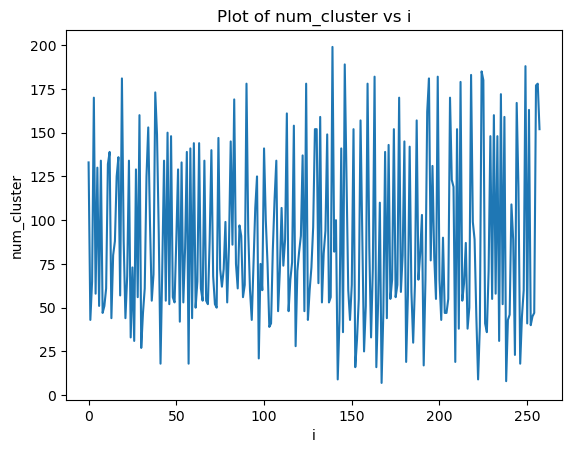

In [66]:
import matplotlib.pyplot as plt

x = range(len(all_adj))
y = num_clusters

plt.plot(x, y)
plt.xlabel('i')
plt.ylabel('num_cluster')
plt.title('Plot of num_cluster vs i')
plt.show()


0.19820939551768674


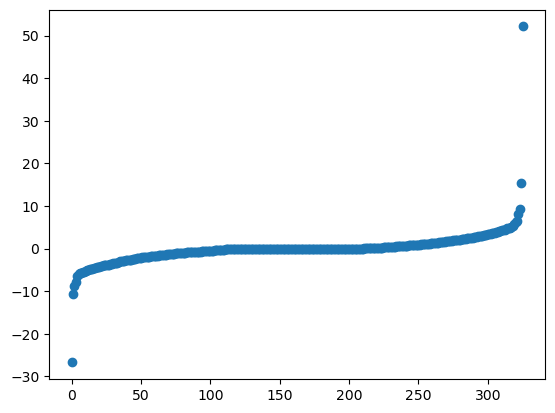

In [52]:
i=3
[a,ind]=graspologic_utils.largest_connected_component(all_adj[i],return_inds=True)
n=len(ind)
adj=all_adj[i][ind][:,ind]
adj_sym = graspologic_utils.symmetrize(adj)
s,u=np.linalg.eig(adj_sym)
plt.scatter(range(adj.shape[0]),np.sort(s))


In [54]:
n

326

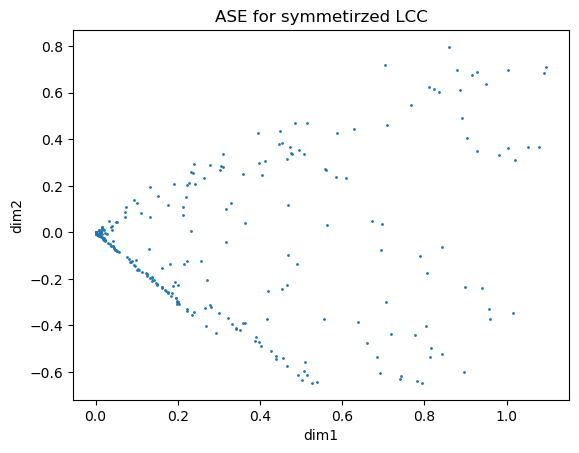

In [72]:
ed=2
ase = AdjacencySpectralEmbed(n_components=ed)
Xhat = ase.fit_transform(adj_sym)
Xhat_list = np.zeros((n, 2*ed))  # Define Xhat_list before assigning values to it
Xhat_list[:,list(np.arange(ed))]=Xhat
#Xhat_list[:,list(np.arange(ed,2*ed))]=Yhat

plt.scatter(Xhat_list[:, 0], Xhat_list[:, 1],s=1)
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('ASE for symmetirzed LCC')
plt.show()




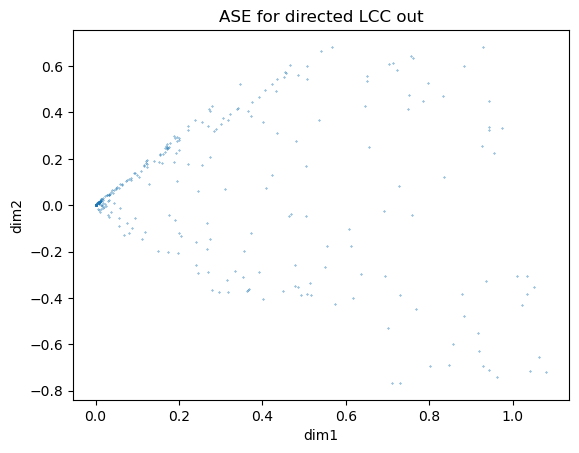

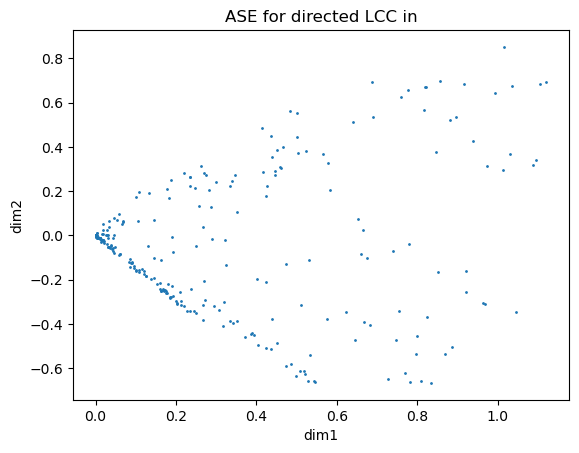

In [75]:
ed=2
ase = AdjacencySpectralEmbed(n_components=ed)
Xhat,Yhat = ase.fit_transform(adj)
Xhat_list = np.zeros((n, 2*ed))  # Define Xhat_list before assigning values to it
Xhat_list[:,list(np.arange(ed))]=Xhat
Xhat_list[:,list(np.arange(ed,2*ed))]=Yhat

plt.scatter(Xhat_list[:, ed], Xhat_list[:, ed+1],s=0.1)
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('ASE for directed LCC out')
plt.show()

plt.scatter(Xhat_list[:, 0], Xhat_list[:, 1],s=1)
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('ASE for directed LCC in')
plt.show()

/Users/tianyichen/opt/anaconda3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


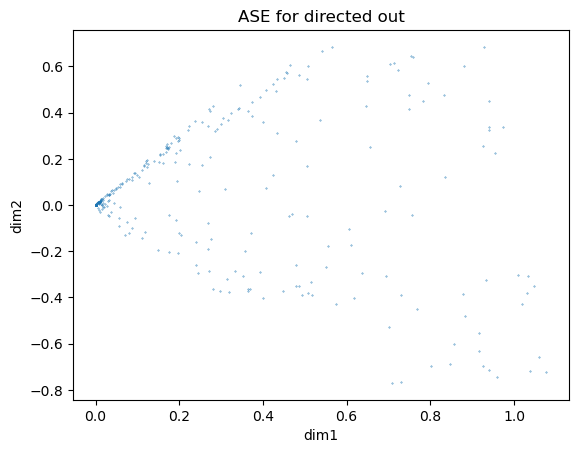

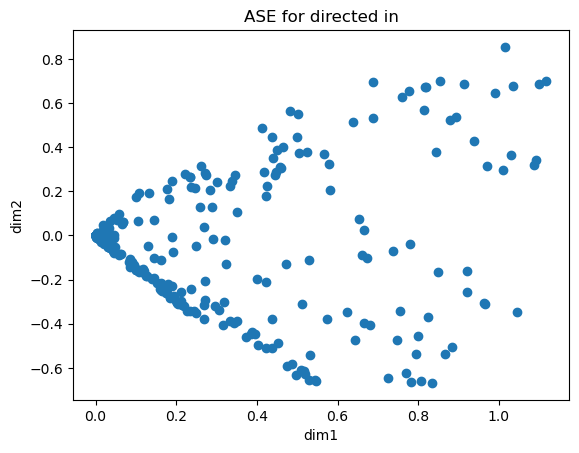

In [74]:
ed=2
ase = AdjacencySpectralEmbed(n_components=ed)
Xhat,Yhat = ase.fit_transform(all_adj[i])
Xhat_list1 = np.zeros((all_adj[i].shape[0], 2*ed))  # Define Xhat_list before assigning values to it
Xhat_list1[:,list(np.arange(ed))]=Xhat
Xhat_list1[:,list(np.arange(ed,2*ed))]=Yhat

plt.scatter(Xhat_list1[:, ed], Xhat_list1[:, ed+1],s=0.1)
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('ASE for directed out')
plt.show()

plt.scatter(Xhat_list1[:, 0], Xhat_list1[:, 1])
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('ASE for directed in')
plt.show()

In [67]:
Xhat_list1.shape
Xhat_list.shape

(326, 4)

In [ ]:
Xhat = ase.fit_transform(adj_sym)
Xhat_list = np.zeros((n, 2*ed))  # Define Xhat_list before assigning values to it
Xhat_list[:,list(np.arange(ed))]=Xhat
#Xhat_list[:,list(np.arange(ed,2*ed))]=Yhat

In [34]:
## time points we selected that are dense enough 
tm=final_data[kk,1]  ## this is there corresponding time 
choosen_time_points=kk ## this is the index of the time points we selected
len(tm)

34

In [35]:
## add zeros to the adj mat such that they have the same dims 
dim = max(number_of_vertices) # Max number of vertices to determine dimension
m=len(all_adj)
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size
for i in range(m):
    ma = all_adj[i]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 

In [36]:
graph_matching=True
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline
for i in range(1, m):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    ofv=res['fun']
    fun_I = np.trace(adj_aug[i].T  @ adj_gm[i-1] )
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    #print(f"Frob diff before GM: {before_norm}, After GM: {after_norm},OFV before GM: {fun_I}, After GM: {ofv}")

In [37]:
D=np.zeros([len(tm),len(tm)])

In [38]:
len(all_adj)

34

<AxesSubplot:title={'center':'Distance matrix between time points'}>

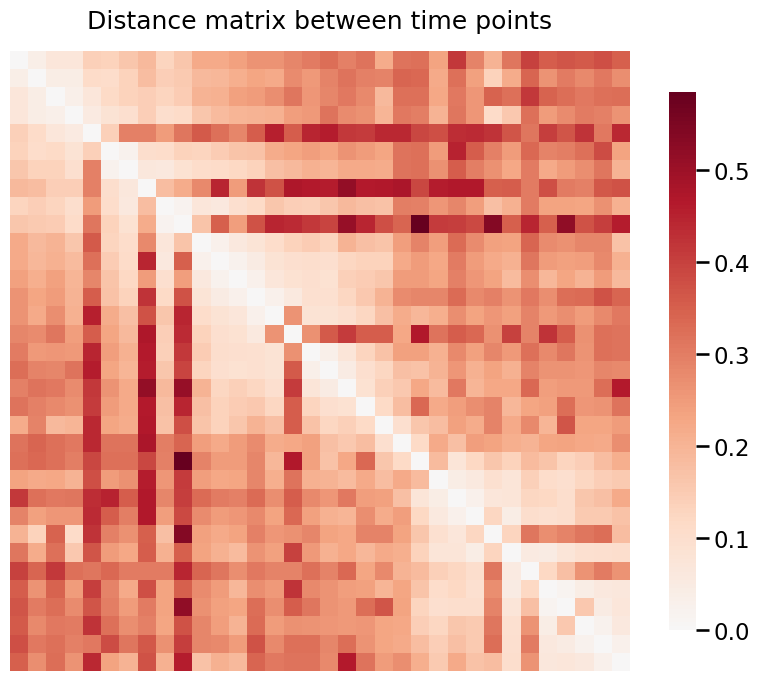

In [39]:
Pairwise_lccc=True
for i in range(len(tm)):
    for j in range(i,len(tm)):
        prod=adj_gm[i] * adj_gm[j]
        [a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
        n=len(ind)
        #print(i,j,n)
        glist=np.zeros([len(choosen_time_points),len(ind),len(ind)])
        glist[i]=adj_gm[i][ind][:,ind]
        glist[j]=adj_gm[j][ind][:,ind]
        #print(graspologic_utils.is_fully_connected(glist[i]))

        #if n<ed_old:
        #    ed=int(ed_old/3)
        #    print("ASE embedding dim",ed)
        

        s = np.linalg.svd(glist[i], compute_uv=False)
        #kneedle=KneeLocator(range(glist[i].shape[0]),s, curve="convex", direction="decreasing")
        #ed=kneedle.knee
        ed=get_elbows(s, n=1, plot=False)[0]+1
        if n<10:
            print("ASE embedding dim",ed,i,j,n)

        Xhat_list=np.zeros([len(tm),n,2*ed])
        ase = AdjacencySpectralEmbed(n_components=ed)
        Xhat, Yhat = ase.fit_transform(glist[i])
        Xhat_list[i][:,list(np.arange(ed))]=Xhat
        Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

        Xhat, Yhat = ase.fit_transform(glist[j])
        Xhat_list[j][:,list(np.arange(ed))]=Xhat
        Xhat_list[j][:,list(np.arange(ed,2*ed))]=Yhat

        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  #Frobenius norm

D=D+D.T
heatmap(D, title="Distance matrix between time points")

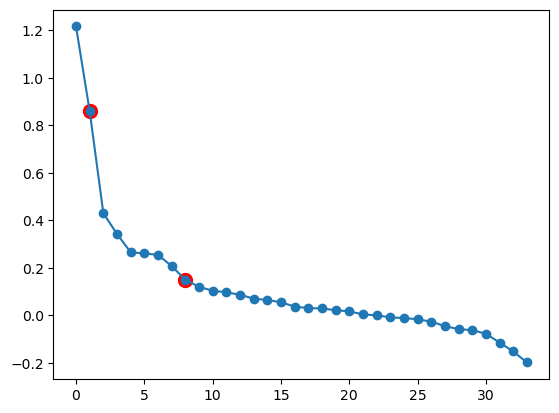

CMDS embedding dim: 9


In [40]:
## CMDS
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
#plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
#plt.xlabel('dimension',fontsize=15)
#plt.ylabel('eigen value',fontsize=15)
#kneedle=KneeLocator(range(len(tm)),w, curve="convex", direction="decreasing")
d=get_elbows(w, n=2, plot=True)[1]+1
print("CMDS embedding dim:", d)
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

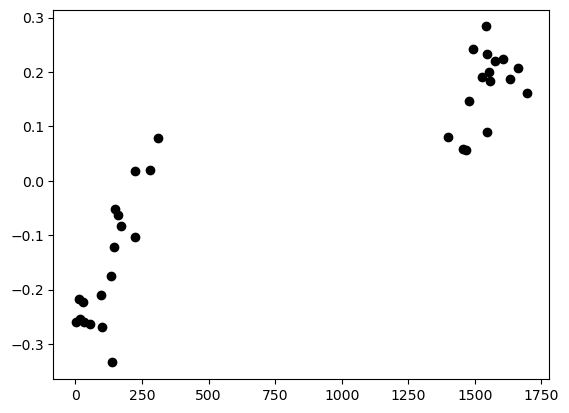

In [41]:
time_diff_chosen = [float(tm[i]) for i in range(len(tm))]
plt.scatter(time_diff_chosen,-MDS[:,0],color='black')

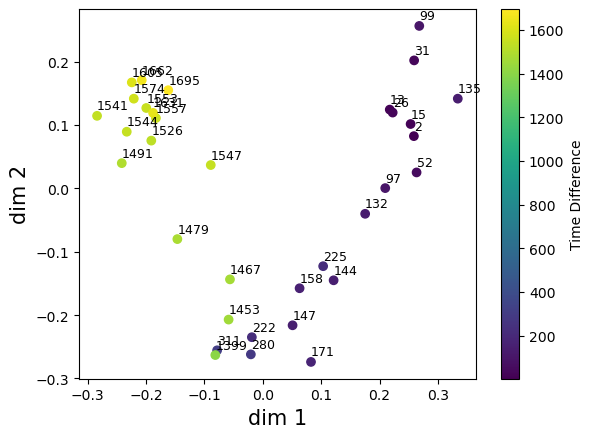

In [42]:


plt.scatter(MDS[:,0], -MDS[:,1], c=time_diff_chosen, cmap='viridis')
for i in range(len(tm)):
    plt.text(MDS[i,0], -MDS[i,1]+0.01, int(time_diff_chosen[i]), fontsize=9)
plt.xlabel("dim 1", fontsize=15)
plt.ylabel("dim 2", fontsize=15)
plt.colorbar(label='Time Difference')
plt.show()


Warning encountered with n_neighbors=2: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Successful with n_neighbors=3


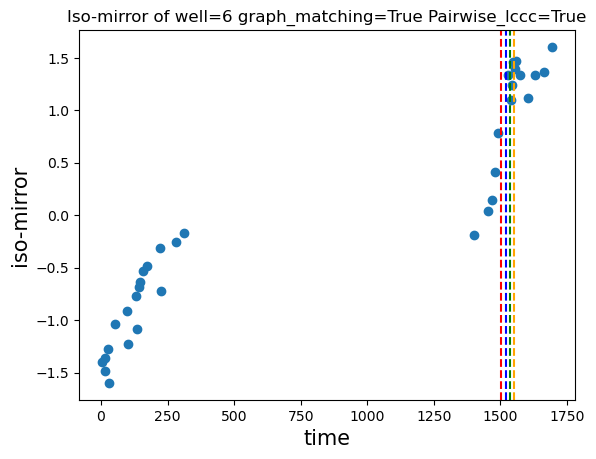

In [44]:
## ISOMAP fitting on CMDS result

optimal_n_neighbors = find_optimal_neighbors(MDS)
embedding = Isomap(n_neighbors=optimal_n_neighbors,n_components=1)
iso = embedding.fit_transform(MDS)
iso=iso[:,0]

if iso[0]>0:
    iso=-iso
else:
    iso=iso  

plt.scatter(time_diff_chosen,iso)
plt.xlabel("time",fontsize=15)
plt.ylabel("iso-mirror",fontsize=15)
plt.title("Iso-mirror of well=" + str(well_number)+' graph_matching='+str(graph_matching)+' Pairwise_lccc='+str(Pairwise_lccc))
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

In [156]:
time = [int(float(final_data[kk,1][choosen_time_points[i]])) for i in range(len(choosen_time_points))]

In [117]:
from sklearn.manifold import Isomap

In [158]:
embedding = Isomap(n_neighbors=3,n_components=1)
iso = embedding.fit_transform(MDS)

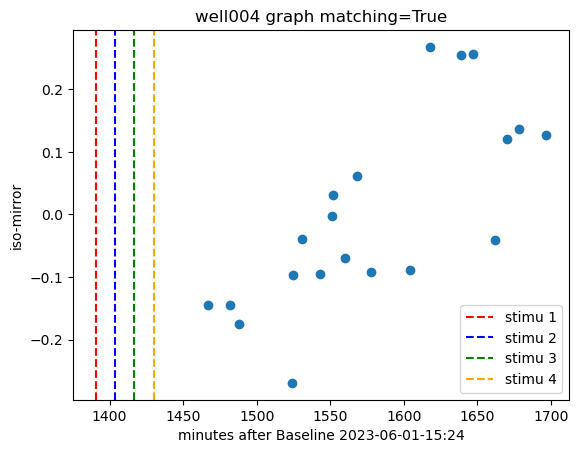

In [159]:

# Plot the scatter plot
plt.scatter(time,-iso)

# Add vertical lines
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-01-15:24')
plt.ylabel('iso-mirror')

# Add a title
plt.title(str(well)+' graph matching='+str(graph_matching))

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [160]:
time

[1467,
 1482,
 1488,
 1524,
 1525,
 1531,
 1543,
 1551,
 1552,
 1560,
 1568,
 1578,
 1604,
 1618,
 1639,
 1647,
 1662,
 1670,
 1678,
 1697]

In [73]:
stimulus_time_diff
time

[1467, 1482, 1525, 1543, 1560, 1578, 1604, 1662]

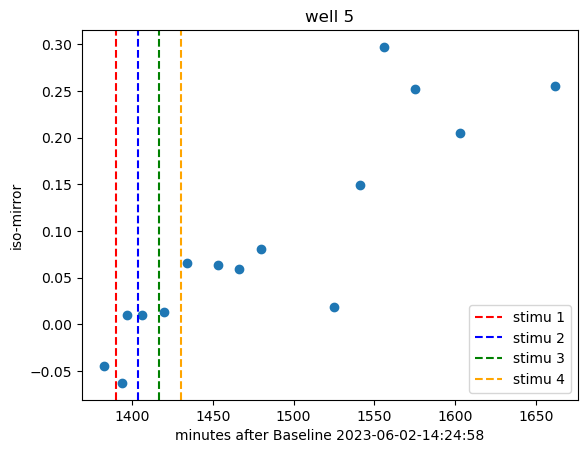

In [199]:
# Plot the scatter plot
plt.scatter(new_list[11:], iso[11:])

# Add vertical lines
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-02-14:24:58')
plt.ylabel('iso-mirror')

# Add a title
plt.title('well 5')

# Add a legend
plt.legend()

# Show the plot
plt.show()
